In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns

/tmp/ipykernel_11617/1604464587.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
search_results = pd.read_json("./lab5/search_results_multimodal_9.jsonl", lines=True, orient="records", encoding="utf-8")
search_results.head()

,activation,batch_size,layers,learning_rate,neurons,train_losses,mse
0,"[relu, he]",10,1,0.05,15,"[0.2062047183, 0.20788325230000002, 0.44459696...",15459.928103
1,"[relu, he]",10,1,0.01,15,"[0.34811635220000003, 0.3487417504, 0.29063819...",1828.746366
2,"[relu, he]",10,1,0.01,10,"[0.417133289, 0.4693072562, 0.4944018010000000...",3706.669063
3,"[relu, he]",10,1,0.01,5,"[0.3656749016, 0.3396009198, 0.3688114749, 0.3...",1690.445836
4,"[relu, he]",10,1,0.05,10,"[0.34855736940000004, 0.3467769526, 0.34305813...",1768.460216


In [3]:
search_results.index.name = "search_id"

## Learning rate analysis

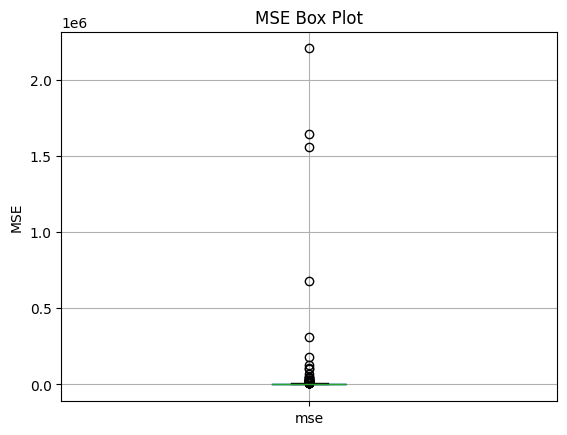

In [4]:
# MSE Violin plot
search_results.boxplot(column="mse")
plt.ylabel("MSE")
plt.title("MSE Box Plot")
plt.show()


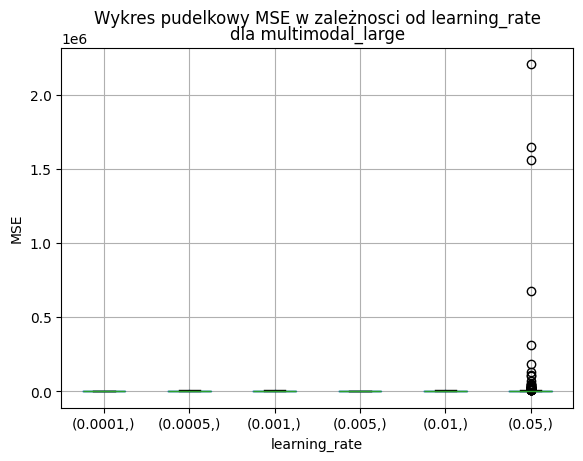

In [5]:
fig = plt.figure()
search_results.boxplot(column="mse", by=["learning_rate"], ax=fig.gca())
fig.suptitle("Wykres pudelkowy MSE w zależnosci od learning_rate")
fig.gca().set_title("dla multimodal_large")
fig.gca().set_ylabel("MSE")
fig.gca().set_xlabel("learning_rate")
plt.show()

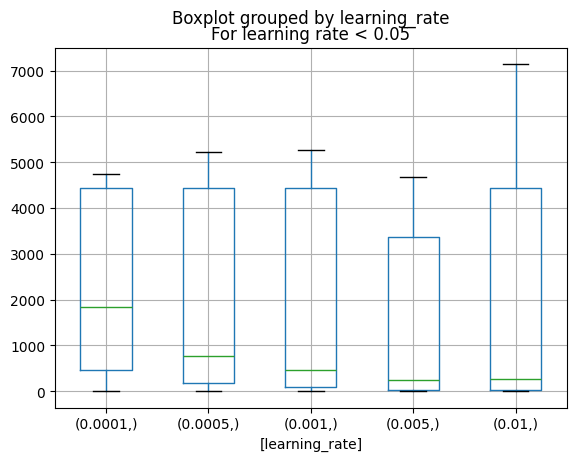

In [6]:
search_results[search_results["learning_rate"] < 0.05].boxplot(column="mse", by=["learning_rate"])
plt.title("For learning rate < 0.05")
plt.show()

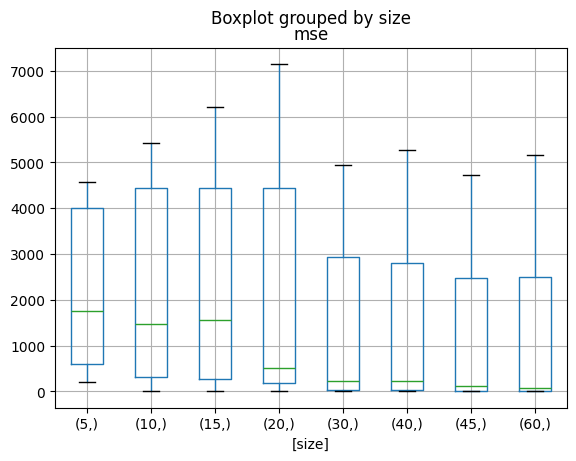

In [7]:
search_results["size"] = search_results["neurons"] * search_results["layers"]
df = search_results.sort_values("size")
df[df["learning_rate"] < 0.05].boxplot(column="mse", by=["size"])
plt.show()

In [8]:
print(
    search_results["neurons"].unique(),
    search_results["layers"].unique()
)

[15 10  5 20] [1 2 3]


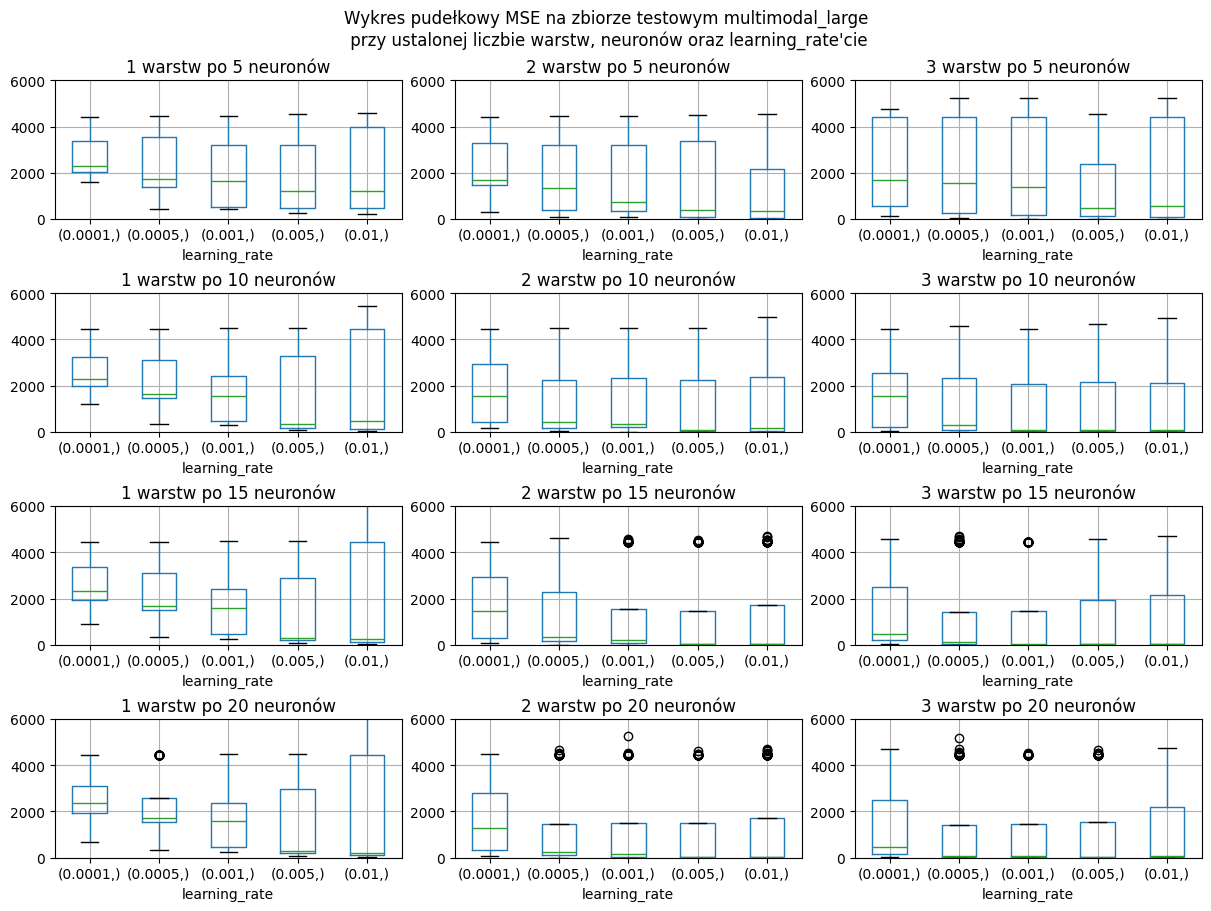

In [9]:
fig, axs = plt.subplots(4, 3, layout="constrained", figsize=(12, 9))
i = 0
for neurons in [5,10,15,20]:
    for layers in [1,2,3]:
        df = search_results[search_results["learning_rate"] < 0.05]
        df = df[(df["neurons"] == neurons) & (df["layers"] == layers)]
        df.boxplot(column="mse", by=["learning_rate"], ax=axs.flat[i])
        axs.flat[i].set_title(f"{layers} warstw po {neurons} neuronów")
        axs.flat[i].set_xlabel(f"learning_rate")
        axs.flat[i].set_ybound(0, 6000)
        i += 1
fig.suptitle("Wykres pudełkowy MSE na zbiorze testowym multimodal_large\n przy ustalonej liczbie warstw, neuronów oraz learning_rate'cie")
plt.show()

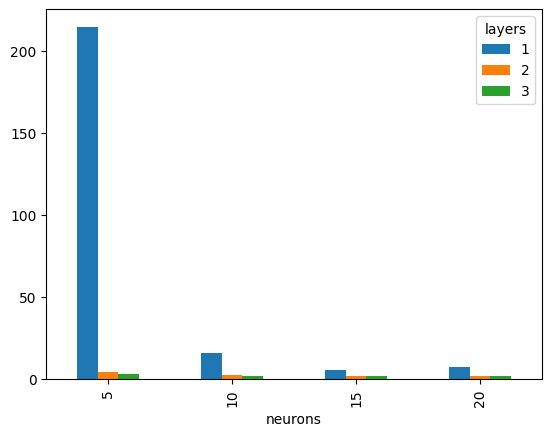

In [10]:
df = search_results.reset_index(drop=False)
df.groupby(["neurons", "layers"])["mse"].min().unstack().plot.bar()
plt.show()

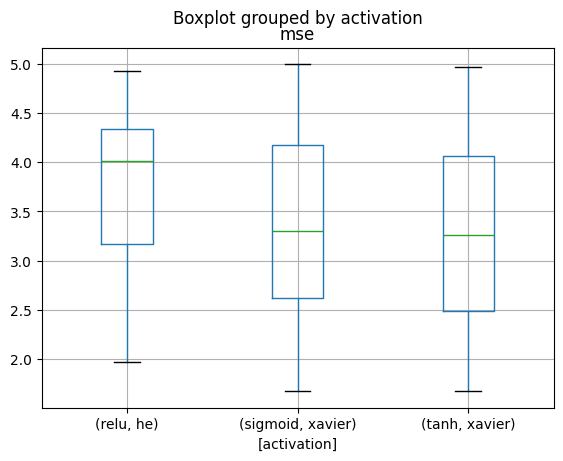

In [ ]:
df = search_results[search_results["mse"] < 5]
df = df[["activation", "mse"]]
df["activation"] = df["activation"].apply(tuple).astype("category")
df.boxplot(by="activation")
plt.show()

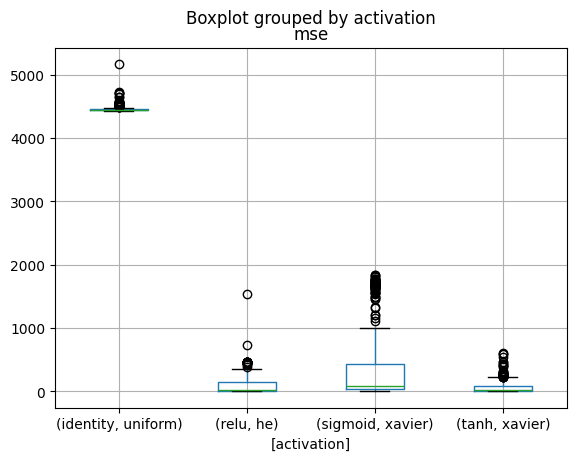

In [ ]:
df = search_results[search_results["learning_rate"] < 0.01]
df = df[(df["layers"] > 2) & (df["neurons"] > 10)]
df["activation"] = df["activation"].apply(tuple).astype("category")
df[["activation", "mse"]].boxplot(by="activation")
plt.show()

## Find the best model

In [12]:
df = search_results[["activation", "neurons", "layers", "learning_rate", "batch_size", "mse"]]
df["activation"] = df["activation"].apply(tuple).astype("category")
df.head()

/tmp/ipykernel_11617/28243181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activation"] = df["activation"].apply(tuple).astype("category")


,activation,neurons,layers,learning_rate,batch_size,mse
search_id,,,,,,
0,"(relu, he)",15,1,0.05,10,15459.928103
1,"(relu, he)",15,1,0.01,10,1828.746366
2,"(relu, he)",10,1,0.01,10,3706.669063
3,"(relu, he)",5,1,0.01,10,1690.445836
4,"(relu, he)",10,1,0.05,10,1768.460216


In [13]:
best_params = df.groupby(
    ["activation", "neurons", "layers", "learning_rate", "batch_size"]
).mean().reset_index().sort_values(by="mse").head(2)
best_params

/tmp/ipykernel_11617/1257510407.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_params = df.groupby(


,activation,neurons,layers,learning_rate,batch_size,mse
1060,"(tanh, xavier)",15,3,0.0005,10,2.823416
1113,"(tanh, xavier)",20,2,0.0010,20,3.249767


In [14]:
training_losses  = best_params[["neurons", "layers", "learning_rate", "batch_size"]].set_index(
    ["neurons", "layers", "learning_rate", "batch_size"]
    ).join(
    search_results.set_index(["neurons", "layers", "learning_rate", "batch_size"])["train_losses"], how="left"
).reset_index()
training_losses.head()

,neurons,layers,learning_rate,batch_size,train_losses
0,15,3,0.0005,10,"[0.306490258, 0.1647082682, 0.1176108583000000..."
1,15,3,0.0005,10,"[0.4311494301, 0.33055132730000003, 0.31339504..."
2,15,3,0.0005,10,"[0.9230451426, 0.8040202386, 0.7487681317, 0.6..."
3,15,3,0.0005,10,"[0.8602597234, 0.853133943, 0.8525337479, 0.87..."
4,15,3,0.0005,10,"[0.306490258, 0.1647082682, 0.1176108583000000..."


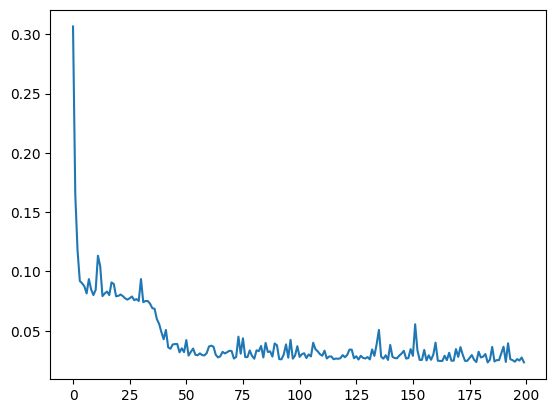

In [15]:
plt.plot(training_losses.iloc[0, 4])
plt.show()

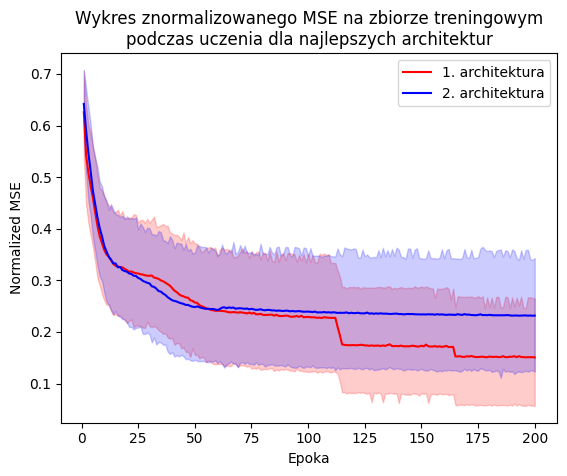

In [16]:
colors = ["red", "blue", "green", "orange", "purple"]
for i, (idx, df) in enumerate(training_losses.groupby(["neurons", "layers", "learning_rate", "batch_size"])):
    df2 = df["train_losses"].reset_index(drop=False).explode("train_losses")
    df2['epoch'] = df2.groupby("index").cumcount()+1
    sns.lineplot(data=df2, x="epoch", y="train_losses", color=colors[i], label=f"{i+1}. architektura")
plt.title("Wykres znormalizowanego MSE na zbiorze treningowym\npodczas uczenia dla najlepszych architektur")
plt.xlabel("Epoka")
plt.ylabel("Normalized MSE")
plt.show()


In [17]:
for i in [1,2]:
    print(f"Best {i} parameters:")
    print(best_params.iloc[i-1])

Best 1 parameters:
activation       (tanh, xavier)
neurons                      15
layers                        3
learning_rate            0.0005
batch_size                   10
mse                    2.823416
Name: 1060, dtype: object
Best 2 parameters:
activation       (tanh, xavier)
neurons                      20
layers                        2
learning_rate             0.001
batch_size                   20
mse                    3.249767
Name: 1113, dtype: object


## Testing on other datasets

In [18]:
params1 = best_params[["activation", "neurons", "layers", "batch_size", "learning_rate"]].iloc[0, ].to_dict()
params2 = best_params[["activation", "neurons", "layers", "batch_size", "learning_rate"]].iloc[1, ].to_dict()

In [22]:
import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy, CategorialCorssEntropy, MeanSquareErrorLoss
from mygrad.optimizers import RMSProp
from mygrad.preprocessors import StandardScaler, IdentityScaler
from mygrad.trainers import CategoricalClassificationTrainer, ProgressBar, EarlyStopping, Trainer as RegressionTrainer
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

### Regression

In [20]:
def eval_regression_model(params, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, output_normalizer):
    model = mc.SimpleDense(
        1,
        1,
        params["layers"],
        params["neurons"],
        params["activation"][0],
        params["activation"][1],
    )
    # Output layer is linear with uniform initialization
    model = mc.Sequential(
        *model.components[:-1], mc.Linear(params["neurons"], 1, "uniform")
    )

    optimizer = RMSProp(
        model.parameters(),
        learning_rate=params["learning_rate"],
        beta=0.9,  # good default value
    )
    loss = MeanSquareErrorLoss()
    train_dataloader = NumpyRegressionDataloader(
        X_train_scaled, y_train_scaled, batch_size=params["batch_size"], shuffle=True
    )
    validation_dataloader = NumpyRegressionDataloader(
        X_test_scaled,
        y_test_scaled,
        batch_size=200,
        shuffle=False,  # batch size for validation set high
    )

    trainer = RegressionTrainer(
        model,
        optimizer,
        loss,
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        plugins=[EarlyStopping(50, warmup=50), ProgressBar()],
    )
    outputs = trainer.train(200)

    y_test_pred = model.forward(X_test_scaled)
    model.zero_grad()

    return outputs["loss"], output_normalizer.reverse(y_test_pred), params

### Eval on steps large

In [26]:
train_df = pd.read_csv("../mio1/regression/steps-large-training.csv")
test_df = pd.read_csv("../mio1/regression/steps-large-test.csv")
X_train = train_df["x"].values.reshape(-1, 1)
y_train = train_df["y"].values.reshape(-1, 1)
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

input_normalizer = StandardScaler()
output_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)
y_train_scaled = output_normalizer.fit_transform(y_train)
X_test_scaled = input_normalizer.transform(X_test)
y_test_scaled = output_normalizer.transform(y_test)

In [27]:
outputs1, _, _ = eval_regression_model(params1, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, output_normalizer)
outputs2, _, _ = eval_regression_model(params2, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, output_normalizer)

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

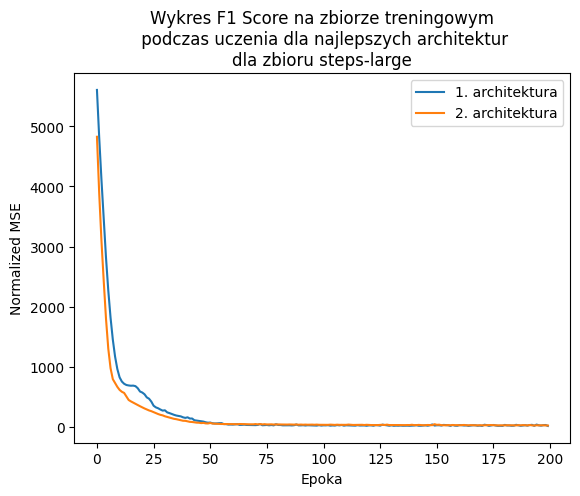

In [25]:
plt.plot(outputs1, label="1. architektura")
plt.plot(outputs2, label="2. architektura")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("Normalized MSE")
plt.title("Wykres F1 Score na zbiorze treningowym\n podczas uczenia dla najlepszych architektur\ndla zbioru steps-large")
plt.show()

### Classification

In [67]:
def eval_classification_model(params, classes, X_train_scaled, y_train_onehot, X_test_scaled, y_test_onehot):
    model = mc.SimpleDense(
        2,
        classes,
        params["layers"],
        params["neurons"],
        params["activation"][0],
        params["activation"][1],
    )
    # Output layer is linear with uniform initialization
    model = mc.Sequential(
        *model.components[:-1], mc.Linear(params["neurons"], classes, "uniform"), mc.Softmax()
    )

    optimizer = RMSProp(
        model.parameters(),
        learning_rate=params["learning_rate"],
        beta=0.9,  # good default value
    )
    loss = CategorialCorssEntropy()
    train_dataloader = NumpyClassificationDataloader(
        X_train_scaled, y_train_onehot, batch_size=params["batch_size"], shuffle=True, is_one_hot=True
    )
    validation_dataloader = NumpyClassificationDataloader(
        X_test_scaled,
        y_test_onehot,
        batch_size=200,
        shuffle=False,  # batch size for validation set high
        is_one_hot=True
    )

    trainer = CategoricalClassificationTrainer(
        model,
        optimizer,
        loss,
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        plugins=[EarlyStopping(50, warmup=50), ProgressBar()],
    )
    outputs = trainer.train(200)

    y_test_pred = model.forward(X_test_scaled)
    model.zero_grad()

    return outputs, np.argmax(y_test_pred, axis=1), params


#### Eval on rings3-regular

In [69]:
train_df = pd.read_csv("../mio1/classification/rings3-regular-training.csv")
test_df = pd.read_csv("../mio1/classification/rings3-regular-test.csv")

X_train = train_df[["x", "y"]].values.reshape(-1, 2)
y_train = train_df["c"].values.reshape(-1, 1)
X_test = test_df[["x", "y"]].values.reshape(-1, 2)
y_test = test_df["c"].values.reshape(-1, 1)

y_train_onehot = mf.onehot_encode(y_train, 3)
y_test_onehot = mf.onehot_encode(y_test, 3)

input_normalizer = StandardScaler()
X_train_scaled = input_normalizer.fit_transform(X_train)
X_test_scaled = input_normalizer.transform(X_test)

outputs1, y_pred_1, _ = eval_classification_model(params1, 3, X_train_scaled, y_train_onehot, X_test_scaled, y_test_onehot)
outputs2, y_pred_2, _ = eval_classification_model(params2, 3, X_train_scaled, y_train_onehot, X_test_scaled, y_test_onehot)

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [56]:
print(mf.fscore(y_pred_1, y_test, 3))
print(mf.fscore(y_pred_2, y_test, 3))

0.9393893318416043
0.9614969957839178
0.9322260260279814


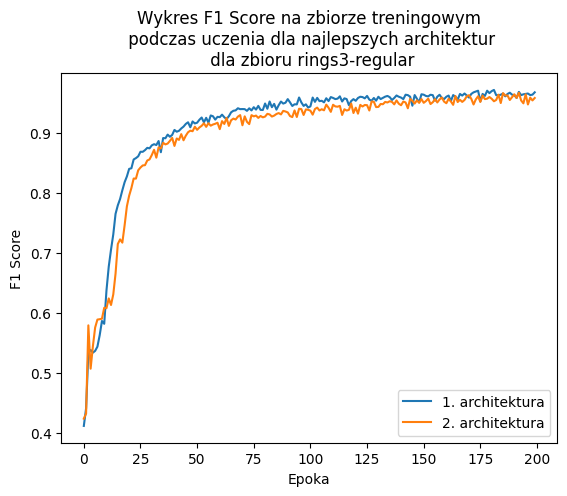

In [71]:
plt.plot(outputs1["fscore"], label="1. architektura")
plt.plot(outputs2["fscore"], label="2. architektura")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("F1 Score")
plt.title("Wykres F1 Score na zbiorze treningowym\n podczas uczenia dla najlepszych architektur\n dla zbioru rings3-regular")
plt.show()

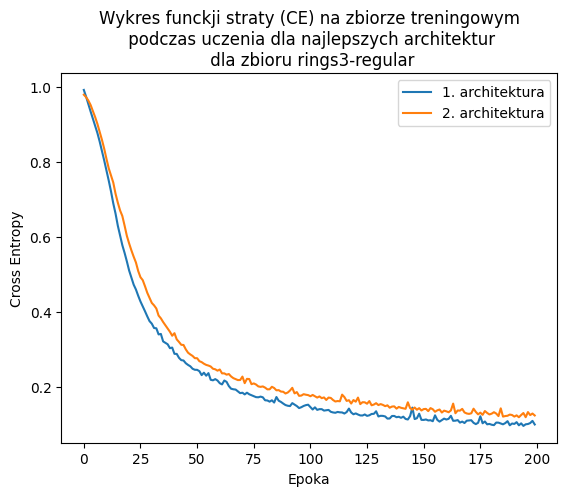

In [72]:
plt.plot(outputs1["loss"], label="1. architektura")
plt.plot(outputs2["loss"], label="2. architektura")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("Cross Entropy")
plt.title("Wykres funckji straty (CE) na zbiorze treningowym\n podczas uczenia dla najlepszych architektur\n dla zbioru rings3-regular")
plt.show()

#### Eval on rings 5 regular

In [81]:
train_df = pd.read_csv("../mio1/classification/rings5-regular-training.csv")
test_df = pd.read_csv("../mio1/classification/rings5-regular-test.csv")

X_train = train_df[["x", "y"]].values.reshape(-1, 2)
y_train = train_df["c"].values.reshape(-1, 1)
X_test = test_df[["x", "y"]].values.reshape(-1, 2)
y_test = test_df["c"].values.reshape(-1, 1)

y_train_onehot = mf.onehot_encode(y_train, 5)
y_test_onehot = mf.onehot_encode(y_test, 5)

input_normalizer = StandardScaler()
X_train_scaled = input_normalizer.fit_transform(X_train)
X_test_scaled = input_normalizer.transform(X_test)

outputs1, y_pred_1, _ = eval_classification_model(params1, 5, X_train_scaled, y_train_onehot, X_test_scaled, y_test_onehot)
outputs2, y_pred_2, _ = eval_classification_model(params2, 5, X_train_scaled, y_train_onehot, X_test_scaled, y_test_onehot)

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:48: RuntimeWarning: invalid value encountered in divide
  fscores = 2 * precision * recall / (precision + recall)


Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:47: RuntimeWarning: invalid value encountered in divide
  recall = tp / np.sum(y_true, axis=0)


In [82]:
print(mf.fscore(y_pred_1, y_test, 5))
print(mf.fscore(y_pred_2, y_test, 5))

0.8789377970304717
0.884361998396536


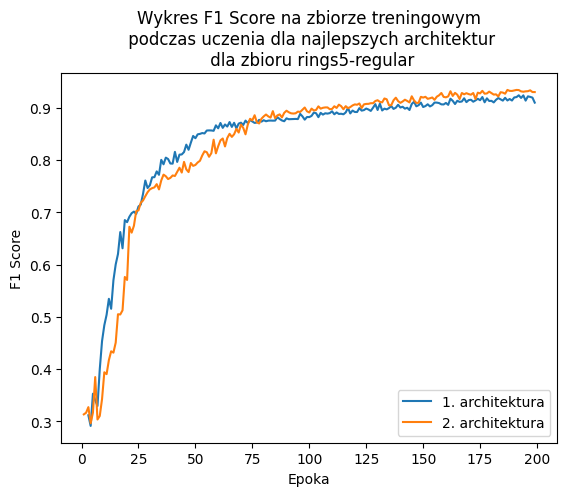

In [83]:
plt.plot(outputs1["fscore"], label="1. architektura")
plt.plot(outputs2["fscore"], label="2. architektura")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("F1 Score")
plt.title("Wykres F1 Score na zbiorze treningowym\n podczas uczenia dla najlepszych architektur\n dla zbioru rings5-regular")
plt.show()

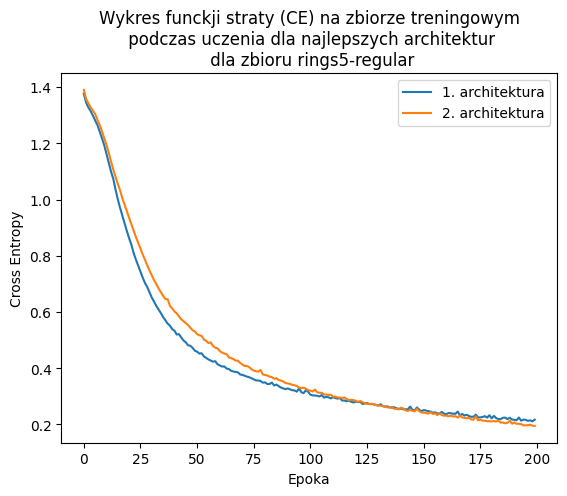

In [84]:
plt.plot(outputs1["loss"], label="1. architektura")
plt.plot(outputs2["loss"], label="2. architektura")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("Cross Entropy")
plt.title("Wykres funckji straty (CE) na zbiorze treningowym\n podczas uczenia dla najlepszych architektur\n dla zbioru rings5-regular")
plt.show()